# Classification – Stroke Prediction

The application of machine learning techniques can provide a great service to medicine. This example is about the stroke prediction. The data can be found on Kaggle (https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) and contains a table of patient information. Later, the data and characteristics are analysed in more detail. Basically, the aim is to predict from the available data whether a patient is at high risk of having a stroke or not. It is supervised learning. The data set therefore contains information on whether the corresponding patient has had a stroke or not.

### Preparations and importing

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import resample
import math
from scipy.stats import chi2_contingency

In [2]:
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

### Saving the Data in DataFrame

It can be seen that there are 5110 patients in total and 10 other characteristics in addition to the information about the occurrence of a stroke.

In [3]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv',index_col='id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


### Dealing with missing data

The first step is to take care of missing data. A search for nan values shows that the column "bmi" contains nan values. These are then replaced by the mean value.

In [4]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [5]:
# Replace missing values with mean
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())
# Eject patients with gender "Other", as only one exist
df = df[df['gender']!='Other']
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### Get to understand the data

We should visualize the data in order to understand it better. For that we begin with coping the DataFrame and categorizing the continues values. In addition, we will also change the 0 and 1 in “hypertension” and “heart_disease” to yes and no.  

In [6]:
# Copy df into df_cat
df_cat = df.copy()

In [7]:
# Categorize
df_cat['age'] = pd.cut(df_cat['age'],bins = list(range(0,int(max(df_cat['age']))+5,5)), include_lowest=True, labels = list(range(0,int(max(df_cat['age'])),5)))
df_cat['avg_glucose_level'] = pd.cut(df_cat['avg_glucose_level'],bins = list(range(50,275,15)), include_lowest=True, labels = list(range(50,260,15)))
df_cat['bmi'] = pd.cut(df_cat['bmi'],bins = list(range(10,100,5)), include_lowest=True, labels = list(range(10,95,5)))

In [8]:
# Change values of int-categoteties for better understanding in graph
df_cat['hypertension'] = df_cat['hypertension'].replace([0,1],['No','Yes'])
df_cat['heart_disease'] = df_cat['heart_disease'].replace([0,1],['No','Yes'])

To get an overview of the stroke patients, we create bar plots. It is noticeable that there are clear differences except for "gender" and "Residence_type". So there are some properties that are suitable for classification.

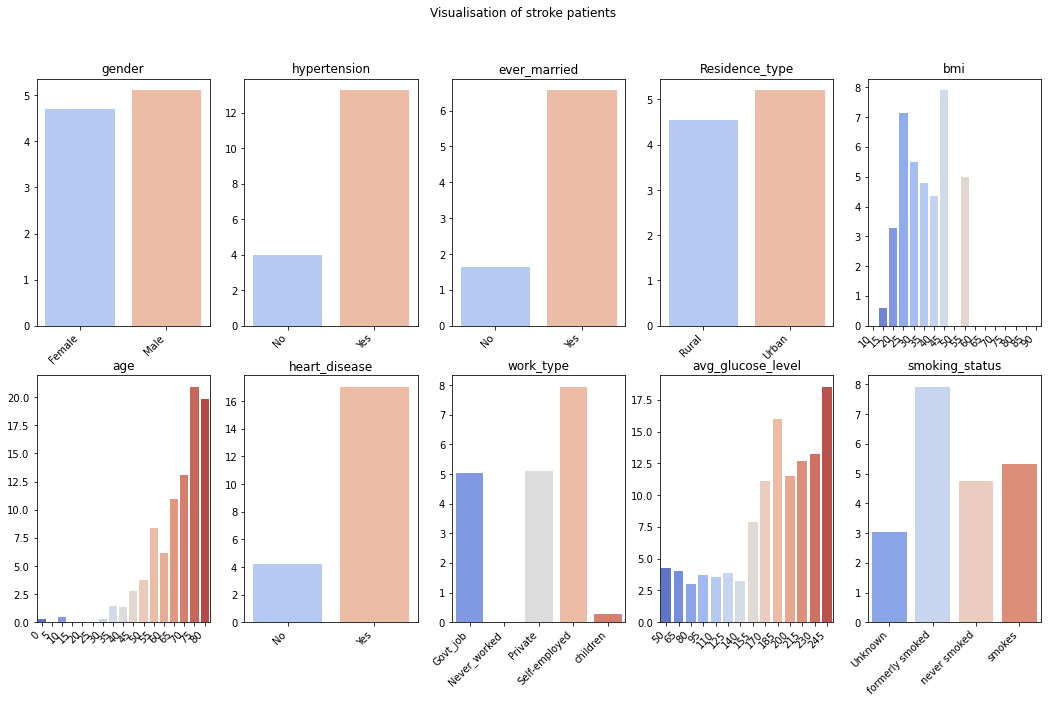

In [9]:
# Bar plot of every feature with stroke = yes 
df_yes = df_cat[df_cat['stroke'] == 1]
#Creat subplot
fig, axes = plt.subplots(2, 5, figsize=(18, 10))

fig.suptitle('Visualisation of stroke patients')

counter = 0

# Loop through all features
for colName in df_cat.loc[:, df_cat.columns != 'stroke'].columns.tolist():
    
    # Groupby to get number of stroke patient for attribute of feature
    df_toPic = (df_yes.groupby(colName).count()/df_cat.groupby(colName).count())

    # Get pos and bars
    bars = df_toPic.index.tolist()
    x_pos = np.arange(len(bars))

    # Get values and multiply by 100 to get %
    y = [n * 100 for n in df_toPic.iloc[:, 1].tolist()]

    sns.barplot(ax=axes[int(counter%2),int(counter/2)], x=x_pos, y=y, palette = "coolwarm")
    axes[int(counter%2),int(counter/2)].set_title(colName)
    axes[int(counter%2),int(counter/2)].set_xticklabels(bars, rotation=45, ha="right")
    
    counter += 1

### Get Cramer's V correlation matrix

To quantify the dependence of Stroke and the other properties, we create a matrix with the CramerV values. It is important to know, that we cannot simply use the pearson function in pd.corr() because we have discrete values. So we have to write our own function.

In [10]:
# Function to calculate the CramersV of two characteristics
def cramers_V(var1,var2):
    # Build cross table
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) 
    # Calculate the Chi^2
    chi2 = chi2_contingency(crosstab)[0]
    # Number of observations
    N = np.sum(crosstab)
    # Get min of number of rows and columns (-1)
    M = min(crosstab.shape)-1
    return (chi2/(N*M))

In [11]:
# Function to create CramersV-Matrix
def cramers_V_df(df):
    # First step is to encode data
    df_encoded = Encode(df)
    # Build CramersV DataFrame
    rows= []
    # Loop through columns
    for var1 in df_encoded:
        col = []
        for var2 in df_encoded :
            # Call function to calc CeamersV
            cramers =cramers_V(df_encoded[var1], df_encoded[var2])
            # Round values
            col.append(round(cramers,5))
        rows.append(col)

    cramers_results = np.array(rows)
    return pd.DataFrame(cramers_results, columns = df_encoded.columns, index =df_encoded.columns)

In [12]:
# Function to encode Data
def Encode(df):
    label = preprocessing.LabelEncoder()
    df_encoded = pd.DataFrame() 

    for i in df.columns :
        df_encoded[i]=label.fit_transform(df[i])
        
    return df_encoded
    

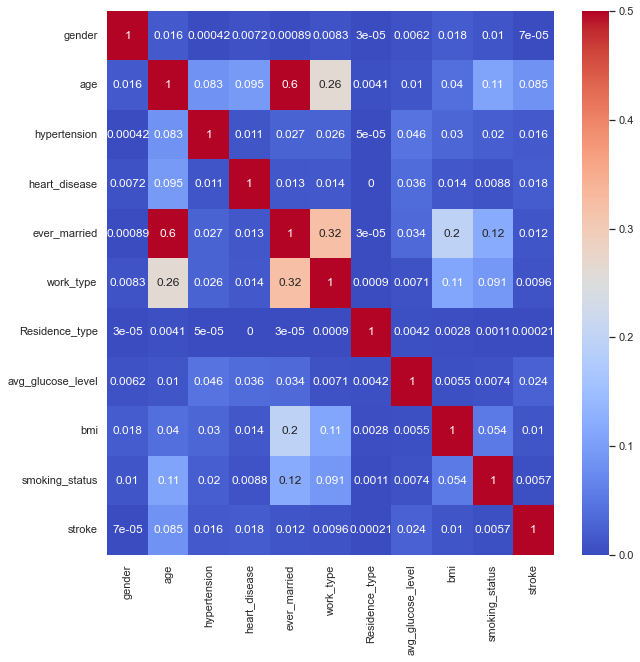

In [13]:
# Show CramersV Matrix as heatmap
sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(cramers_V_df(df_cat), annot=True, vmax=0.5, cmap='coolwarm')
plt.show()

The Cramers V matrix shows very nice the dependencies between the properties. If we focus on  “stroke”, we can see stronger dependencies from “age” and “avg_glucose_level”. As we already saw before, the dependency with "gender" and "Residence_type" is very low. So we will not use them for the classification.

### Preparations for modelling

Now we can finally jump to the modelling of the data. For this we will have to prepare the data abit more. We will not use the poorly correlated characteristics.

In [14]:
# Drop unimportant columns
df_final = df.drop(['gender','Residence_type'], axis=1)
# Change labels to numbers
df_final['ever_married'] = df_final['ever_married'].replace(['No','Yes'],[0,1])
df_final['work_type'] = df_final['work_type'].replace(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],[0,1,2,3,4])
df_final['smoking_status'] = df_final['smoking_status'].replace(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],[0,1,2,3])

#### Problem: Unbalanced data

The data is heavily unbalanced. Only around 5% of the patients in the data had a stroke as the next line of code shows. This is of course great for the patients but bad for the prediction, because a very good result with an accuracy of 95% would already be achieved, when all the patients are put in the category “no stroke”.

In [15]:
df_final.groupby('stroke').count().iloc[:,0]

stroke
0    4860
1     249
Name: age, dtype: int64

We can prove this with a quick classification of the raw data with the k-Nearest-Neighbour Algorithm. For this the data need to be normalized first and separated into test and train data. 

In [16]:
# Array with all characteristics to make prediciton
X_od = df_final.loc[:, df_final.columns != 'stroke'].values
# Normalize it
X_od = preprocessing.StandardScaler().fit(X_od).transform(X_od.astype(float))
# Array with stroke data
y_od = df_final['stroke']

# Put into train and test data set
X_od_train, X_od_test, y_od_train, y_od_test = train_test_split(X_od, y_od, test_size=0.3, random_state=3)

In [17]:
# import KNN
from sklearn.neighbors import KNeighborsClassifier

k = 2
# Build model
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_od_train,y_od_train)
# Make prediciton of test data
y_od_predict = neigh.predict(X_od_test)
# Get accuracy, precision and recall from comparing prediciton with actual test data
print("KNN's Accuracy: " + str(metrics.accuracy_score(y_od_test, y_od_predict)*100))
print("KNN's Precision: " + str(metrics.precision_score(y_od_test, y_od_predict)*100))
print("KNN's Recall: " + str(metrics.recall_score(y_od_test, y_od_predict)*100))

KNN's Accuracy: 95.04240052185257
KNN's Precision: 20.0
KNN's Recall: 4.477611940298507


As expected, the accuracy is very good at 95%. However, the data were very poorly classified, as the poor values for the precision and recall show. Fortunately, there are ways around this problem.  

### Imbalanced Data handling

The best way to deal with our situation is to up sample or data. New stroke patients are generated from existing real stroke patients. The other options would be to down sample. But then it would only be a small data set and the models would have correspondingly high uncertainties.

In [18]:
# Spilt data into stroke and no stroke
df_final_stroke = df_final[df_final['stroke'] == 1]
df_final_Nostroke = df_final[df_final['stroke'] == 0]

# Upsample Stroke Data until we have a equal amount of stroke and no stroke
df_final_stroke_upsampled = resample(df_final_stroke,replace=True,n_samples=df_final_Nostroke.shape[0])

# Put data back together
df_final = pd.concat([df_final_stroke_upsampled,df_final_Nostroke])

Before modelling, the data is normalised and divided into train and test.

In [19]:
# Dividing into arrays with X and y
X = df_final.loc[:, df_final.columns != 'stroke'].values
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
y = df_final['stroke']

In [20]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

### Final modeling

Now it is finally time for the classification of the data. For this we will try different algorithms to compare the performance and judge which is the most suitable. We are trying here KNN, Decision Tree, Logistic Regression and SVM. To find the best algorithm we compare the accuracy, precision and recall.  

#### KNN

In [21]:
k = 2
# Build model
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
# Make prediciton of test data
y_predict = neigh.predict(X_test)
# Get accuracy, precision and recall from comparing prediciton with actual test data
print("KNN's Accuracy: " + str(metrics.accuracy_score(y_test, y_predict)*100))
print("KNN's Precision: " + str(metrics.precision_score(y_test, y_predict)*100))
print("KNN's Recall: " + str(metrics.recall_score(y_test, y_predict)*100))

KNN's Accuracy: 96.98216735253772
KNN's Precision: 94.30420711974111
KNN's Recall: 100.0


#### Descision Tree

We will make an extra step for the decision tree by testing the best depth. For this we test the accuracy, precision and recall as a function of the depth.

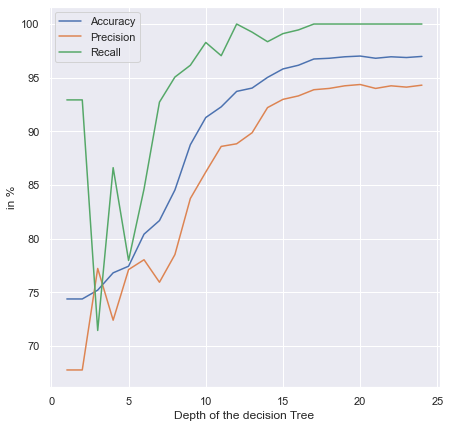

In [22]:
from sklearn.tree import DecisionTreeClassifier

# Arrays containing the corresponding data for different depths
DT_x, DT_Acc, DT_Pre, DT_Rec = [], [], [], []

for i in range(1,25):
    # Build model
    drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = i)
    drugTree.fit(X_train,y_train)

    # Make prediciton of test data
    y_predict = drugTree.predict(X_test)
    
    # Add data to Arrays
    DT_x += [i]
    DT_Acc += [metrics.accuracy_score(y_test, y_predict)*100]
    DT_Pre += [metrics.precision_score(y_test, y_predict)*100]
    DT_Rec += [metrics.recall_score(y_test, y_predict)*100]
    
# Make plot
plt.figure(figsize=(7, 7))
plt.plot(DT_x, DT_Acc, label = "Accuracy")
plt.plot(DT_x, DT_Pre, label = "Precision")
plt.plot(DT_x, DT_Rec, label = "Recall")

plt.xlabel('Depth of the decision Tree')
plt.ylabel('in %')

plt.legend()
plt.show()

A clear increase can be seen for all three values. But we shouldn’t choose the depth to high, since there is a risk of overfitting. Therefore, we decide here for a depth of 19.

In [23]:
# Get accuracy, precision and recall from comparing prediciton with actual test data
print("DecisionTrees Accuracy: " + str(DT_Acc[19]))
print("DecisionTrees Precision: " + str(DT_Pre[19]))
print("DecisionTrees Recall: " + str(DT_Rec[19]))

DecisionTrees Accuracy: 97.0164609053498
DecisionTrees Precision: 94.36528497409327
DecisionTrees Recall: 100.0


#### Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

# Build model
LR = LogisticRegression(C=0.1, solver='liblinear').fit(X_train,y_train)
# Make prediciton of test data
y_predict = LR.predict(X_test)
# Get accuracy, precision and recall from comparing prediciton with actual test data
print("Logistic Regression's Accuracy: " + str(metrics.accuracy_score(y_test, y_predict)*100))
print("Logistic Regression's Precision: " + str(metrics.precision_score(y_test, y_predict)*100))
print("Logistic Regression's Recall: " + str(metrics.recall_score(y_test, y_predict)*100))

Logistic Regression's Accuracy: 75.41152263374485
Logistic Regression's Precision: 74.2782152230971
Logistic Regression's Recall: 77.69389155799588


#### SVM

In [25]:
from sklearn import svm

# Build model
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 
# Make prediciton of test data
y_predict = clf.predict(X_test)
# Get accuracy, precision and recall from comparing prediciton with actual test data
print("SVM's Accuracy: " + str(metrics.accuracy_score(y_test, y_predict)*100))
print("SVM's Precision: " + str(metrics.precision_score(y_test, y_predict)*100))
print("SVM's Recall: " + str(metrics.recall_score(y_test, y_predict)*100))

SVM's Accuracy: 78.60082304526749
SVM's Precision: 76.75016056518946
SVM's Recall: 82.0178448867536


### Conclusion

Very good results can be achieved with KNN and decision trees. The logistic regression and SVM are not as good. With this result patients could be helped all over the world. A doctor could for example use our model to calculate the risk of a patient to have a stroke in the future. From this, individual therapies can then be developed to reduce the risk in the long term. This shows how powerful a simple classification algorithm can be.